# Logistic Regression

## Setup



In [0]:
from __future__ import print_function

import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [2]:
COLUMN_NAMES = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
        
FEATURE_NAMES = COLUMN_NAMES[:-1]
TARGET_NAME = COLUMN_NAMES[-1]

SPECIES_NAMES = ['Iris Setosa', 'Iris Versicolor', 'Iris Virginica']

print("Features: {}".format(FEATURE_NAMES))
print("Target: {}".format(TARGET_NAME))

Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Target: species


In [3]:
training_file_url = "http://download.tensorflow.org/data/iris_training.csv"
training_dataframe = pd.read_csv(training_file_url, names=COLUMN_NAMES, header=0)

test_file_url = "http://download.tensorflow.org/data/iris_test.csv"
test_dataframe = pd.read_csv(test_file_url, names=COLUMN_NAMES, header=0)

print("Training dataframe:")
display.display(training_dataframe)

print("Test dataframe:")
display.display(test_dataframe)

Training dataframe:


,sepal_length,sepal_width,petal_length,petal_width,species
0,6.4,2.8,5.6,2.2,2
1,5.0,2.3,3.3,1.0,1
2,4.9,2.5,4.5,1.7,2
3,4.9,3.1,1.5,0.1,0
4,5.7,3.8,1.7,0.3,0
...,...,...,...,...,...
115,5.5,2.6,4.4,1.2,1
116,5.7,3.0,4.2,1.2,1
117,4.4,2.9,1.4,0.2,0
118,4.8,3.0,1.4,0.1,0


Test dataframe:


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.9,3.0,4.2,1.5,1
1,6.9,3.1,5.4,2.1,2
2,5.1,3.3,1.7,0.5,0
3,6.0,3.4,4.5,1.6,1
4,5.5,2.5,4.0,1.3,1
...,...,...,...,...,...
25,6.1,3.0,4.6,1.4,1
26,5.2,4.1,1.5,0.1,0
27,6.7,3.1,4.7,1.5,1
28,6.7,3.3,5.7,2.5,2


In [0]:
def preprocess_features(dataframe):
  selected_features = dataframe[[
    "sepal_length",
    "sepal_width",
    "petal_length",
    "petal_width",
  ]]  
  processed_features = selected_features.copy()
  return processed_features

def preprocess_targets(dataframe):
  processed_targets = pd.DataFrame()
  processed_targets[TARGET_NAME] = dataframe[TARGET_NAME]
  return processed_targets

In [5]:
training_examples = preprocess_features(training_dataframe.head(80))
training_targets = preprocess_targets(training_dataframe.head(80))

validation_examples = preprocess_features(training_dataframe.tail(40))
validation_targets = preprocess_targets(training_dataframe.tail(40))

print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,sepal_length,sepal_width,petal_length,petal_width
count,80.0,80.0,80.0,80.0
mean,6.0,3.1,4.0,1.3
std,0.9,0.5,1.8,0.8
min,4.4,2.0,1.0,0.1
25%,5.2,2.8,1.7,0.4
50%,6.0,3.0,4.5,1.5
75%,6.7,3.3,5.4,1.9
max,7.9,4.4,6.9,2.5


Validation examples summary:


,sepal_length,sepal_width,petal_length,petal_width
count,40.0,40.0,40.0,40.0
mean,5.5,3.0,3.2,0.9
std,0.7,0.4,1.7,0.7
min,4.4,2.3,1.3,0.1
25%,5.0,2.8,1.5,0.2
50%,5.5,3.0,3.5,1.0
75%,6.0,3.4,4.7,1.4
max,7.7,3.8,6.7,2.5


Training targets summary:


,species
count,80.0
mean,1.2
std,0.8
min,0.0
25%,0.0
50%,1.0
75%,2.0
max,2.0


Validation targets summary:


,species
count,40.0
mean,0.7
std,0.7
min,0.0
25%,0.0
50%,1.0
75%,1.0
max,2.0


In [0]:
def create_feature_columns_fn(features):
  return set([tf.feature_column.numeric_column(feature) for feature in features])

In [0]:
def input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
  features = {key:np.array(value) for key,value in dict(features).items()}                                            
 
  ds = Dataset.from_tensor_slices((features,targets))
  ds = ds.batch(batch_size).repeat(num_epochs)
    
  if shuffle:
    ds = ds.shuffle(10000)
    
  features2, targets2 = ds.make_one_shot_iterator().get_next()
  return features2, targets2

## Train a LinearClassifier model



In [0]:
def train_linear_classifier_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):

  periods = 10
  steps_per_period = steps / periods
  
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)  
  
  linear_classifier = tf.estimator.LinearClassifier(
      feature_columns=create_feature_columns_fn(training_examples),
      optimizer=my_optimizer,
      n_classes=3
  )
    
  training_input_fn = lambda: input_fn(
      training_examples, 
      training_targets[TARGET_NAME], 
      batch_size=batch_size)
  
  predict_training_input_fn = lambda: input_fn(
      training_examples, 
      training_targets[TARGET_NAME], 
      num_epochs=1, 
      shuffle=False)
  
  predict_validation_input_fn = lambda: input_fn(
      validation_examples, 
      validation_targets[TARGET_NAME], 
      num_epochs=1, 
      shuffle=False)
  
  print("Model training started...")
  print("LogLoss (on training data):")
  training_log_losses = []
  validation_log_losses = []
  
  for period in range (0, periods):
    linear_classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )

    training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
    training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
    
    validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
    validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
    
    training_log_loss = metrics.log_loss(training_targets, training_probabilities)
    validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)

    print("  period %02d : %0.2f" % (period, training_log_loss))

    training_log_losses.append(training_log_loss)
    validation_log_losses.append(validation_log_loss)
    
  print("Model training finished.")
  
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.tight_layout()
  plt.plot(training_log_losses, label="training")
  plt.plot(validation_log_losses, label="validation")
  plt.legend()

  return linear_classifier

Model training started...
LogLoss (on training data):
  period 00 : 0.79
  period 01 : 0.63
  period 02 : 0.53
  period 03 : 0.47
  period 04 : 0.43
  period 05 : 0.39
  period 06 : 0.37
  period 07 : 0.34
  period 08 : 0.33
  period 09 : 0.31
Model training finished.


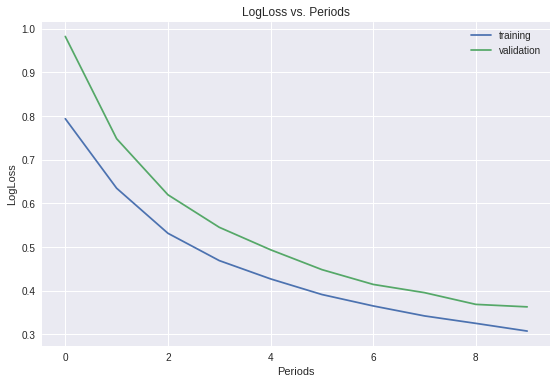

In [9]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.001,
    steps=1000,
    batch_size=20,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

## Evaluate on Test data

In [10]:
test_examples = preprocess_features(test_dataframe)
test_targets = preprocess_targets(test_dataframe)

predict_test_input_fn = lambda: input_fn(
  test_examples, 
  test_targets[TARGET_NAME], 
  num_epochs=1, 
  shuffle=False)

test_probabilities = linear_classifier.predict(input_fn=predict_test_input_fn)
test_probabilities = np.array([item['probabilities'] for item in test_probabilities])
    
test_log_loss = metrics.log_loss(test_targets, test_probabilities)
print("Final LogLoss (on test data): %0.2f" % test_log_loss)

Final LogLoss (on test data): 0.40
